In [1]:
import os
import time
import torch
import faiss
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import umap.plot
from tqdm.auto import tqdm
from typing import List
from pathlib import Path
from sklearn.model_selection import train_test_split

from utils.lightgcn import LightGCN
from utils.metrics import compute_bpr_loss, get_metrics

/Users/hwangyungwan/miniforge3/envs/ds_p313/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/Users/hwangyungwan/miniforge3/envs/ds_p313/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/Users/hwangyungwan/miniforge3/envs/ds_p313/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than

# Load Dataset

In [2]:
DOMAIN = "fashion"

current_dir = os.path.abspath(os.curdir)
base_dir = "/".join(current_dir.split("/")[:-1])
dataset_dir = Path(base_dir).joinpath(f"workspace/dataset/{DOMAIN}/interactions")
print(dataset_dir)

/Users/hwangyungwan/Library/Mobile Documents/com~apple~CloudDocs/Documents/workspace/lecture/rec_sys/workspace/dataset/fashion/interactions


In [3]:
df = pd.read_parquet(dataset_dir)
df.head()

,user_id,item_id,timestamp,action,age,gender,title,color,style,fit,material,season,sleeve,category
0,1,3092,2025-09-21 03:01:00,click,46,F,"트렌디한 스포티룩, 세미오버핏 레깅스 in 여름",아이보리,스포티,세미오버핏,울,여름,7부,레깅스
1,1,8879,2025-09-21 03:02:00,click,46,F,"트렌디한 스포티룩, 슬림핏 레깅스 in 여름",아이보리,스포티,슬림핏,메쉬,여름,롱슬리브,레깅스
2,1,1880,2025-09-21 03:03:00,click,46,F,필수템! 스포티 무드의 간절기용 레깅스,아이보리,스포티,세미오버핏,데님,간절기,숏슬리브,레깅스
3,1,6154,2025-09-21 03:13:00,click,46,F,여름 감성 슬림핏 폴리 레깅스,아이보리,스포티,슬림핏,폴리,여름,롱슬리브,레깅스
4,1,8642,2025-09-21 03:13:00,wishlist,46,F,"트렌디한 스포티룩, 레귤러핏 레깅스 in 겨울",아이보리,스포티,레귤러핏,코튼,겨울,7부,레깅스


# Preprocess

In [4]:
df.head()

,user_id,item_id,timestamp,action,age,gender,title,color,style,fit,material,season,sleeve,category
0,1,3092,2025-09-21 03:01:00,click,46,F,"트렌디한 스포티룩, 세미오버핏 레깅스 in 여름",아이보리,스포티,세미오버핏,울,여름,7부,레깅스
1,1,8879,2025-09-21 03:02:00,click,46,F,"트렌디한 스포티룩, 슬림핏 레깅스 in 여름",아이보리,스포티,슬림핏,메쉬,여름,롱슬리브,레깅스
2,1,1880,2025-09-21 03:03:00,click,46,F,필수템! 스포티 무드의 간절기용 레깅스,아이보리,스포티,세미오버핏,데님,간절기,숏슬리브,레깅스
3,1,6154,2025-09-21 03:13:00,click,46,F,여름 감성 슬림핏 폴리 레깅스,아이보리,스포티,슬림핏,폴리,여름,롱슬리브,레깅스
4,1,8642,2025-09-21 03:13:00,wishlist,46,F,"트렌디한 스포티룩, 레귤러핏 레깅스 in 겨울",아이보리,스포티,레귤러핏,코튼,겨울,7부,레깅스


# Train

In [5]:
def train(df: pd.DataFrame, save_path: Path, params: dict, device: str = "cpu") -> None:
    EPOCHS = params["epochs"]
    BATCH_SIZE = params["batch_size"]
    n_layers = params["n_layers"]
    latent_dim = params["latent_dim"]
    DECAY = params["decay"]
    TOP_K = params["top_k"]

    model = LightGCN(data=df, n_layers=n_layers, latent_dim=latent_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
    model = model.to(device)

    loss_list_epoch = []
    mf_loss_list_epoch = []
    reg_loss_list_epoch = []

    recall_list = []
    precision_list = []

    train_time_list = []
    eval_time_list = []

    _, test = train_test_split(df.values, test_size=0.2, random_state=42)
    df_test = pd.DataFrame(test, columns=df.columns)

    print(f"Training start - {device}")
    for epoch in tqdm(range(EPOCHS), desc="Training..", dynamic_ncols=True):
        n_batch = int(df.shape[0] / BATCH_SIZE)
        print(f"Batch size: {n_batch}")

        mf_loss_list = []
        reg_loss_list = []
        final_loss_list = []

        train_start_time = time.time()
        model.train()

        # batch index
        for _ in range(n_batch):
            optimizer.zero_grad()

            users, pos_items, neg_items = model.load_data(batch_size=BATCH_SIZE)

            users_emb, pos_emb, neg_emb, user_emb_0, pos_emb_0, neg_emb_0 = (
                model.forward(users, pos_items, neg_items)
            )

            mf_loss, reg_loss = compute_bpr_loss(
                users, users_emb, pos_emb, neg_emb, user_emb_0, pos_emb_0, neg_emb_0
            )
            reg_loss = DECAY * reg_loss
            final_loss = mf_loss + reg_loss

            final_loss.backward()
            optimizer.step()

            mf_loss_list.append(mf_loss.item())
            reg_loss_list.append(reg_loss.item())
            final_loss_list.append(final_loss.item())

        print(f"Epoch Progress: {epoch+1} epoch")

        train_end_time = time.time()
        train_time = round(train_end_time - train_start_time, 2)
        train_time_list.append(train_time)

        print("Elapsed time(sec): {:.2f}".format(train_time))

        model.eval()
        with torch.no_grad():
            user_embed, item_embed, _, _ = model.propagate_through_layers()
            test_top_k_recall, test_top_k_precision = get_metrics(
                user_embed_wts=user_embed,
                item_embed_wts=item_embed,
                test_data=df_test,
                top_k=TOP_K,
                metrics=["recall", "precision"],
            )

        eval_time = time.time() - train_end_time
        eval_time_list.append(eval_time)

        mf_loss_list_epoch.append(round(np.mean(mf_loss_list), 5))
        reg_loss_list_epoch.append(round(np.mean(reg_loss_list), 5))
        loss_list_epoch.append(round(np.mean(final_loss_list), 5))

        recall_list.append(round(test_top_k_recall, 4))
        precision_list.append(round(test_top_k_precision, 4))

        print("Loss: {:.5f}".format(np.mean(final_loss_list)))
        print(
            f"Top {TOP_K} - Recall: {round(test_top_k_recall, 4)}, Precision : {round(test_top_k_precision, 4)}"
        )

    filepath = save_path.joinpath("performance_metrics.csv")
    pd.DataFrame(
        {
            "epochs": range(1, EPOCHS + 1),
            "mf_loss": mf_loss_list_epoch,
            "reg_loss": reg_loss_list_epoch,
            "loss": loss_list_epoch,
            "recall": recall_list,
            "precision": precision_list,
            "train_time": train_time_list,
            "eval_time": eval_time_list,
        }
    ).to_csv(filepath, index=False)

    user_map = dict(sorted(model.user_map.items(), key=lambda item: item[1]))
    user_map = {
        "user_id": user_map.keys(),
        "idx": user_map.values(),
        "vector": user_embed.cpu().detach().numpy().tolist(),
    }
    df = pd.DataFrame.from_dict(user_map)
    df["vector_normalized"] = df["vector"].apply(lambda x: x / np.linalg.norm(x))
    filepath = str(save_path.joinpath("user_vector.parquet"))
    df.to_parquet(filepath)

    item_map = dict(sorted(model.item_map.items(), key=lambda item: item[1]))
    item_map = {
        "item_id": item_map.keys(),
        "idx": item_map.values(),
        "vector": item_embed.cpu().detach().numpy().tolist(),
    }
    df = pd.DataFrame.from_dict(item_map)
    df["vector_normalized"] = df["vector"].apply(lambda x: x / np.linalg.norm(x))
    filepath = str(save_path.joinpath("item_vector.parquet"))
    df.to_parquet(filepath)

In [6]:
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Number of GPU: {device_count}")

device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    "n_layers": 3,
    "latent_dim": 64,
    "epochs": 10,
    "batch_size": 1024,
    "decay": 0.0001,
    "top_k": 10,
}
save_path = Path(base_dir).joinpath(f"workspace/model/{DOMAIN}/lightgcn")
save_path.mkdir(parents=True, exist_ok=True)

In [7]:
train(df=df, save_path=save_path, params=params, device=device)

Training start - cpu


Training..:   0%|          | 0/10 [00:00<?, ?it/s]

Batch size: 157
Epoch Progress: 1 epoch
Elapsed time(sec): 9.17
Loss: 0.23547
Top 10 - Recall: 0.5689, Precision : 0.1866
Batch size: 157
Epoch Progress: 2 epoch
Elapsed time(sec): 9.09
Loss: 0.02301
Top 10 - Recall: 0.5911, Precision : 0.1934
Batch size: 157
Epoch Progress: 3 epoch
Elapsed time(sec): 10.11
Loss: 0.01290
Top 10 - Recall: 0.6009, Precision : 0.196
Batch size: 157
Epoch Progress: 4 epoch
Elapsed time(sec): 8.90
Loss: 0.01052
Top 10 - Recall: 0.607, Precision : 0.198
Batch size: 157
Epoch Progress: 5 epoch
Elapsed time(sec): 8.87
Loss: 0.00950
Top 10 - Recall: 0.608, Precision : 0.1985
Batch size: 157
Epoch Progress: 6 epoch
Elapsed time(sec): 8.85
Loss: 0.00895
Top 10 - Recall: 0.608, Precision : 0.1985
Batch size: 157
Epoch Progress: 7 epoch
Elapsed time(sec): 8.84
Loss: 0.00876
Top 10 - Recall: 0.6084, Precision : 0.1987
Batch size: 157
Epoch Progress: 8 epoch
Elapsed time(sec): 8.88
Loss: 0.00858
Top 10 - Recall: 0.6101, Precision : 0.1991
Batch size: 157
Epoch Progre

# Metrics

In [8]:
df_metrics = pd.read_csv(save_path.joinpath("performance_metrics.csv"))

In [9]:
df_metrics.head()

,epochs,mf_loss,reg_loss,loss,recall,precision,train_time,eval_time
0,1,0.23355,0.00191,0.23547,0.5689,0.1866,9.17,0.306439
1,2,0.01859,0.00442,0.02301,0.5911,0.1934,9.09,0.446950
2,3,0.00752,0.00538,0.01290,0.6009,0.1960,10.11,0.374213
3,4,0.00459,0.00593,0.01052,0.6070,0.1980,8.90,0.272826
4,5,0.00324,0.00627,0.00950,0.6080,0.1985,8.87,0.272348


## Loss

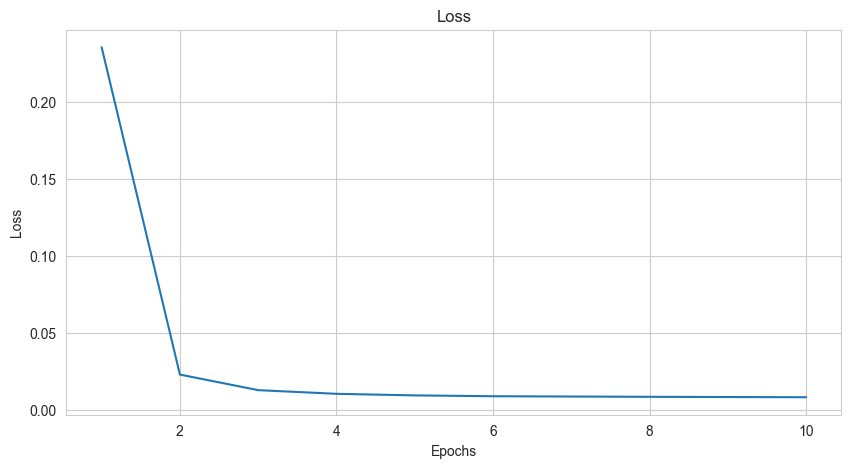

In [10]:
plt.figure(figsize=(10, 5), dpi=100)
sns.lineplot(data=df_metrics, x="epochs", y="loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

## Recall & Precision

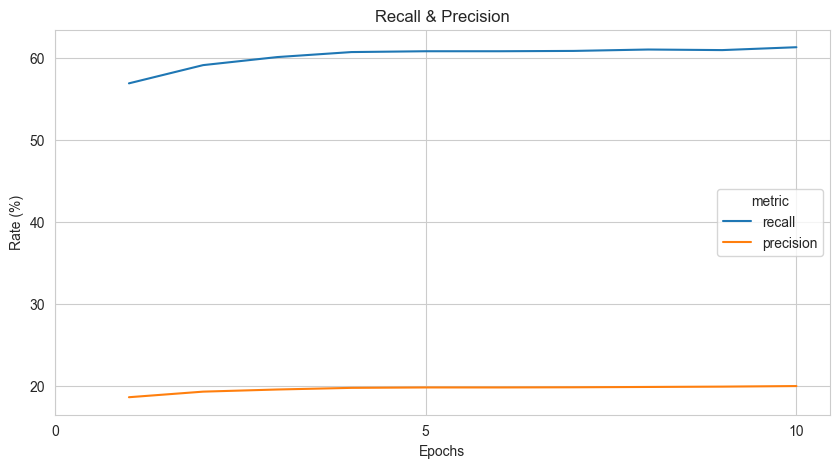

In [11]:
plt.figure(figsize=(10, 5), dpi=100)

df_recall_precision = df_metrics[["epochs", "recall", "precision"]].melt(
    id_vars="epochs", var_name="metric", value_name="value"
)
df_recall_precision["value"] = df_recall_precision["value"] * 100

sns.lineplot(data=df_recall_precision, x="epochs", y="value", hue="metric")
plt.xlabel("Epochs")
plt.ylabel("Rate (%)")
plt.title("Recall & Precision")
plt.xticks(np.linspace(0, params["epochs"], int(params["epochs"] / 5) + 1))
plt.show()

# Embedding Vectors

In [12]:
df_user_vectors = pd.read_parquet(save_path.joinpath("user_vector.parquet"))
df_item_vectors = pd.read_parquet(save_path.joinpath("item_vector.parquet"))

In [13]:
user_vectors = np.array(df_user_vectors["vector_normalized"].tolist())
item_vectors = np.array(df_item_vectors["vector_normalized"].tolist())

## User Vectors

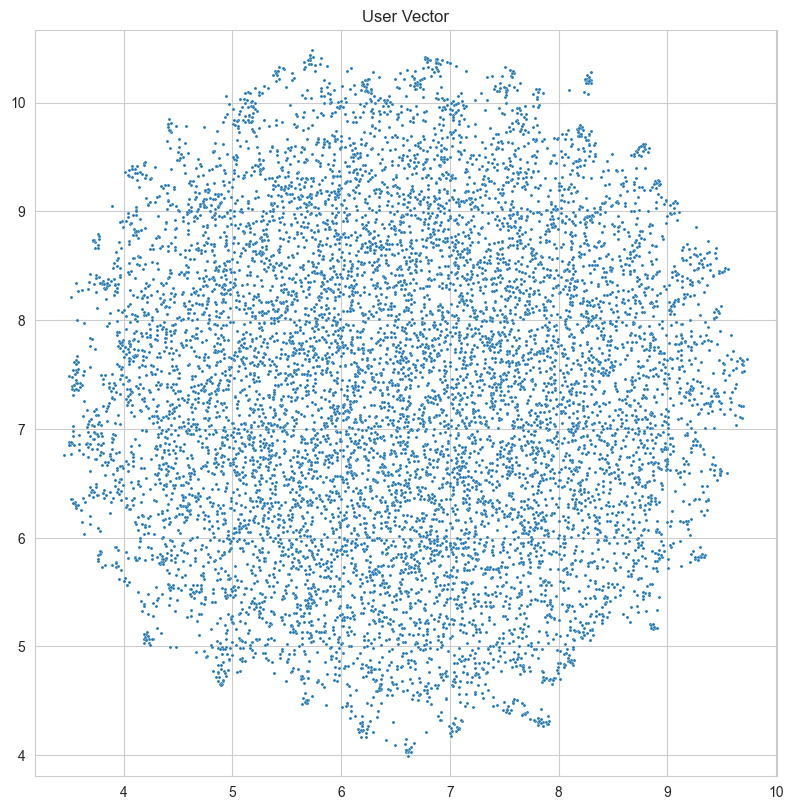

In [14]:
reducer = umap.UMAP(metric="cosine")
embeddings = reducer.fit_transform(user_vectors)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], s=5, legend=False)
plt.gca().set_aspect("equal", "datalim")
plt.tight_layout()
plt.title("User Vector")
plt.show()

## Item Vectors

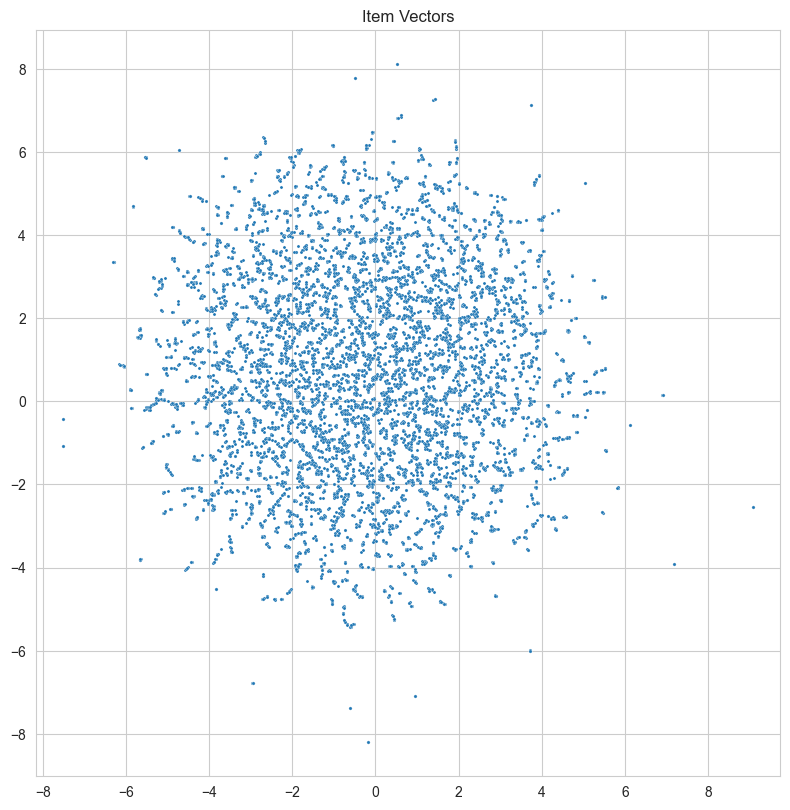

In [15]:
reducer = umap.UMAP(metric="cosine")
embeddings = reducer.fit_transform(item_vectors)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], s=5, legend=False)
plt.gca().set_aspect("equal", "datalim")
plt.tight_layout()
plt.title("Item Vectors")
plt.show()

# Vector Similarity Search

## User Similarity

In [16]:
index = faiss.IndexFlatIP(params["latent_dim"])
index.add(user_vectors)


def find_similar_vectors(vector: np.ndarray, top_k: int = 5) -> dict:
    result = {}
    scores, indices = index.search(vector, top_k)

    for rank, idx in enumerate(indices[0]):
        sim_score = scores[0][rank]
        result[idx.item()] = sim_score.item()
        print(f"{rank+1}. {idx} (score: {sim_score:.4f})")

    return result


user_idx = 200
similar_indices = find_similar_vectors(vector=user_vectors[user_idx].reshape(1, -1))

1. 200 (score: 1.0000)
2. 5155 (score: 0.5281)
3. 4880 (score: 0.5270)
4. 1725 (score: 0.5025)
5. 8426 (score: 0.5021)


In [17]:
input_user_id = df_user_vectors[df_user_vectors["idx"] == user_idx]["user_id"].item()

similar_user_ids = df_user_vectors[df_user_vectors["idx"].isin(similar_indices.keys())][
    "user_id"
].tolist()
similar_user_ids = similar_user_ids[1:]

print(f"User ID: {input_user_id}")
for t in sorted(df[df["user_id"] == input_user_id]["title"]):
    print(t)

User ID: 201
가을 감성 루즈핏 모달 후드티
간절기 시즌, 캐주얼 무드의 올리브 폴리 숏슬리브 루즈핏 베스트
간절기 크롭핏 화이트 모달 7부 셔츠
간절기에 어울리는 화이트 셔츠
겨울 시즌, 러블리 무드의 라벤더 나일론 롱슬리브 루즈핏 원피스
레귤러핏 실루엣의 나일론 베스트
베이지 컬러의 빈티지 스타일 모달 후드티
봄 감성 오버핏 레이온 티셔츠
세미오버핏 실루엣의 스웨이드 원피스
트렌디한 포멀룩, 세미오버핏 셔츠 in 겨울
필수템! 포멀 무드의 간절기용 셔츠


In [18]:
for uid in similar_user_ids:
    print(f"User ID: {uid}")
    for t in sorted(df[df["user_id"] == uid]["title"]):
        print(t)
    print("-----------------------------------")

User ID: 1726
가을 감성 오버핏 메쉬 레깅스
가을 레귤러핏 라벤더 모달 숏 코트
간절기 크롭핏 화이트 모달 7부 셔츠
간절기에 어울리는 화이트 셔츠
겨울 시즌, 시크 무드의 화이트 플리스 민소매 레귤러핏 스커트
겨울에 어울리는 라벤더 코트
봄 감성 크롭핏 퍼 코트
여름 루즈핏 화이트 린넨 롱 스커트
트렌디한 러블리룩, 세미오버핏 후드티 in 여름
트렌디한 레트로룩, 크롭핏 레깅스 in 가을
트렌디한 포멀룩, 세미오버핏 셔츠 in 겨울
포멀 무드의 라벤더 코트
필수템! 러블리 무드의 여름용 후드티
필수템! 레트로 무드의 간절기용 레깅스
필수템! 포멀 무드의 간절기용 셔츠
화이트 컬러의 시크 스타일 아크릴 스커트
-----------------------------------
User ID: 4881
겨울 시즌, 러블리 무드의 라벤더 나일론 롱슬리브 루즈핏 원피스
겨울 크롭핏 블랙 울 롱슬리브 청바지
루즈핏 실루엣의 아크릴 티셔츠
미니멀 무드의 카키 블라우스
봄 시즌, 스포티 무드의 스카이블루 플리스 민소매 루즈핏 레깅스
블랙 컬러의 레트로 스타일 모달 청바지
블랙 컬러의 레트로 스타일 코튼 청바지
세미오버핏 실루엣의 스웨이드 원피스
스카이블루 컬러의 스포티 스타일 가죽 레깅스
여름 시즌, 스포티 무드의 스카이블루 나일론 7부 슬림핏 레깅스
여름 한정 코튼 소재 스카이블루 레깅스
여름에 어울리는 블랙 청바지
올리브 컬러의 빈티지 스타일 코튼 티셔츠
카키 컬러의 미니멀 스타일 아크릴 블라우스
트렌디한 레트로룩, 슬림핏 청바지 in 간절기
트렌디한 레트로룩, 슬림핏 청바지 in 여름
필수템! 미니멀 무드의 가을용 블라우스
-----------------------------------
User ID: 5156
가을 한정 코튼 소재 레드 블라우스
간절기 크롭핏 화이트 모달 7부 셔츠
간절기에 어울리는 화이트 셔츠
네이비 컬러의 캐주얼 스타일 나일론 티셔츠
댄디 무드의 레드 블라우스
봄 감성 크롭핏 플리스 티셔츠
봄에 어울리는 네이비 티셔츠
빈티지 무드의 아이

## Item Similarity

In [19]:
item_metadata_path = Path(base_dir).joinpath(
    f"workspace/dataset/{DOMAIN}/item_metadata.parquet"
)
df_item = pd.read_parquet(item_metadata_path)

In [20]:
index = faiss.IndexFlatIP(params["latent_dim"])
index.add(item_vectors)


def find_similar_vectors(vector: np.ndarray, top_k: int = 5) -> dict:
    result = {}
    scores, indices = index.search(vector, top_k)

    for rank, idx in enumerate(indices[0]):
        sim_score = scores[0][rank]
        result[idx.item()] = sim_score.item()
        print(f"{rank+1}. {idx} (score: {sim_score:.4f})")

    return result


item_idx = 200
similar_indices = find_similar_vectors(vector=item_vectors[item_idx].reshape(1, -1))

1. 200 (score: 1.0000)
2. 3814 (score: 0.9809)
3. 6185 (score: 0.9795)
4. 6434 (score: 0.9775)
5. 9066 (score: 0.9462)


In [21]:
input_item_id = df_item_vectors[df_item_vectors["idx"] == item_idx]["item_id"].item()

similar_item_ids = df_item_vectors[df_item_vectors["idx"].isin(similar_indices.keys())][
    "item_id"
].tolist()
similar_item_ids = similar_item_ids[1:]

print(f"Item ID: {input_item_id}")
df_item[df_item["item_id"] == input_item_id]["title"].item()

Item ID: 201


'가을 한정 레이온 소재 오렌지 코트'

In [22]:
for item_id in similar_item_ids:
    print(f"Item ID: {item_id}")
    print(df_item[df_item["item_id"] == item_id]["title"].item())
    print("-----------------------------------")

Item ID: 3815
겨울 시즌, 러블리 무드의 오렌지 린넨 롱슬리브 세미오버핏 코트
-----------------------------------
Item ID: 6189
간절기 레귤러핏 오렌지 모달 7부 코트
-----------------------------------
Item ID: 6439
봄 감성 슬림핏 메쉬 코트
-----------------------------------
Item ID: 9072
봄 시즌, 러블리 무드의 오렌지 나일론 롱 슬림핏 코트
-----------------------------------


## Recommendation

In [2]:
import numpy as np
import hnswlib

num_users = 10_000
num_items = 10_000
dim = 64
k = 10  # top-K 추천 개수

# -----------------------------
# 2. HNSWlib 인덱스 구축
# -----------------------------
# space="cosine" → 내부적으로 1 - cosine similarity 사용
p = hnswlib.Index(space="cosine", dim=dim)

# efConstruction=200, M=32 정도면 균형 (구축 속도 vs 검색 품질)
p.init_index(max_elements=num_items, ef_construction=200, M=32)
p.add_items(item_vectors, ids=np.arange(num_items))

# 검색 시 리콜/지연시간 조절하는 파라미터
p.set_ef(64)

print(f"Index built with {p.get_current_count()} items")

# -----------------------------
# 3. 검색 예시
# -----------------------------
# 유저 1명 → Top-K 아이템
labels, distances = p.knn_query(user_vectors[0].reshape(1, -1), k=k)
print("\n[User 0 결과]")
print("추천 아이템 ID:", labels[0])
print("Cosine distance:", distances[0])
print("Cosine similarity:", 1 - distances[0])  # 거리 → 유사도로 변환

# 유저 배치 (예: 100명)
labels_batch, distances_batch = p.knn_query(user_vectors[:100], k=k)
print("\n[User 0~99 배치 결과]")
print("Shape:", labels_batch.shape, distances_batch.shape)

Item vectors: (10000, 64)
User vectors: (10000, 64)
Index built with 10000 items

[User 0 결과]
추천 아이템 ID: [6305 6901 6663 3996 4275 1531 5052 3565  976 6954]
Cosine distance: [0.58374083 0.58971894 0.594519   0.59596    0.6112287  0.6131436
 0.61442745 0.6245545  0.6248994  0.6270299 ]
Cosine similarity: [0.41625917 0.41028106 0.40548098 0.40403998 0.3887713  0.38685638
 0.38557255 0.3754455  0.3751006  0.3729701 ]

[User 0~99 배치 결과]
Shape: (100, 10) (100, 10)


In [ ]:
import numpy as np
import hnswlib
from typing import Optional, Sequence, Tuple, Any


def build_hnsw_index(
    item_vectors: np.ndarray,
    ids: Optional[Sequence[int]] = None,
    *,
    space: str = "cosine",
    M: int = 32,
    ef_construction: int = 200,
    ef_search: int = 64,
    normalize: bool = False,
    random_seed: int = 42,
) -> Tuple[Any, np.ndarray]:
    """
    HNSWlib 인덱스를 생성하고 아이템 벡터를 추가합니다.

    Parameters
    ----------
    item_vectors : np.ndarray
        (n_items, dim) 형태의 아이템 임베딩 배열.
    ids : Optional[Sequence[int]]
        인덱스에 등록할 아이템 ID. None이면 [0..n_items-1] 자동 생성.
    space : str
        "cosine", "l2", "ip" 중 하나. 일반적인 추천에선 "cosine" 권장.
        주의: hnswlib에서 "cosine"은 distance=1-cosine_similarity 입니다.
    M : int
        그래프의 연결성(메모리/품질 트레이드오프). 16~64 범위 권장.
    ef_construction : int
        인덱스 구축 시 탐색 폭. 클수록 구축 느려지고 검색 품질↑.
    ef_search : int
        검색 시 탐색 폭(리콜/지연시간 트레이드오프). 이후 set_ef로 변경 가능.
    normalize : bool
        True면 item_vectors를 L2 정규화 후 인덱싱(코사인 지표 사용 시 권장).
    random_seed : int
        재현성을 위한 시드.

    Returns
    -------
    index : hnswlib.Index
        빌드 및 add_items가 완료된 인덱스 객체.
    item_ids : np.ndarray
        인덱스에 실제로 등록된 ID 배열(모양: (n_items,)).

    Notes
    -----
    - space='cosine'일 때는 보통 item_vectors를 정규화하고(user도 정규화 후 검색)
      distance를 1 - cos_sim으로 해석합니다.
    """
    if not isinstance(item_vectors, np.ndarray):
        item_vectors = np.asarray(item_vectors, dtype=np.float32)
    else:
        item_vectors = item_vectors.astype(np.float32, copy=False)

    if item_vectors.ndim != 2:
        raise ValueError("item_vectors는 (n_items, dim) 2차원 배열이어야 합니다.")

    n_items, dim = item_vectors.shape
    if n_items == 0:
        raise ValueError("item_vectors가 비어 있습니다.")

    # 선택적 정규화(코사인 지표 사용 시 권장)
    if normalize:
        norms = np.linalg.norm(item_vectors, axis=1, keepdims=True)
        norms = np.clip(norms, 1e-12, None)
        item_vectors = item_vectors / norms

    # ID 준비
    if ids is None:
        item_ids = np.arange(n_items, dtype=np.int64)
    else:
        item_ids = np.asarray(ids)
        if item_ids.shape[0] != n_items:
            raise ValueError(
                f"ids 길이({item_ids.shape[0]})가 n_items({n_items})와 다릅니다."
            )
        if item_ids.ndim != 1:
            raise ValueError("ids는 1차원 시퀀스여야 합니다.")
        if len(np.unique(item_ids)) != len(item_ids):
            raise ValueError("ids에 중복이 있습니다.")

    # 인덱스 생성 및 구축
    index = hnswlib.Index(space=space, dim=dim)
    index.init_index(
        max_elements=n_items, ef_construction=int(ef_construction), M=int(M)
    )
    index.set_num_threads(0)  # 가용 스레드 자동
    index.set_ef(int(ef_search))
    index.set_seed(int(random_seed))

    # 벡터 추가
    index.add_items(item_vectors, ids=item_ids)

    # 검증
    current = index.get_current_count()
    if current != n_items:
        raise RuntimeError(
            f"인덱스에 추가된 아이템 수가 일치하지 않습니다: {current} vs {n_items}"
        )

    return index, item_ids

In [ ]:
import numpy as np
from typing import List, Tuple, Union, Any


def recommend_with_ann(
    user_vectors: Union[np.ndarray, List[float]],
    ann_index: Any,
    item_vectors: Union[np.ndarray, List[List[float]]],
    top_k: int = 10,
    ef: int = None,
    ensure_user_normalized: bool = False,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    HNSWlib 인덱스를 사용해 유저 벡터 기준 Top-K 아이템을 검색합니다.

    Parameters
    ----------
    user_vectors : np.ndarray | List[float]
        - (dim,) 또는 (n_users, dim) 형태의 유저 임베딩.
        - space='cosine' 인덱스일 경우, item_vectors가 정규화되어 있다면
          user_vectors도 정규화(ensure_user_normalized=True)하는 것을 권장합니다.
    ann_index : Any
        - hnswlib.Index 인스턴스(미리 build&add_items 완료된 상태).
        - space="cosine"으로 생성되었다고 가정합니다.
    item_vectors : np.ndarray | List[List[float]]
        - (n_items, dim) 형태의 아이템 임베딩. 차원 검증용(인덱스와 일치하는지 확인).
          인덱스가 이미 구축되어 있으므로 검색에는 직접 사용되지 않습니다.
    top_k : int
        - 유저당 반환할 Top-K 개수.
    ef : int | None
        - 검색 시 리콜/지연시간을 조절하는 파라미터. 주어지면 ann_index.set_ef(ef) 호출.
    ensure_user_normalized : bool
        - True일 경우 유저 벡터를 L2 정규화한 뒤 검색합니다.
          주의: 인덱스 구축 시 아이템 벡터도 동일하게 정규화되어 있었다는 전제를 권장.

    Returns
    -------
    labels : np.ndarray
        - 모양: (n_users, top_k). 각 유저별 추천 아이템 ID(인덱스에 등록한 ID).
    similarities : np.ndarray
        - 모양: (n_users, top_k). 코사인 유사도(1 - distance).
          hnswlib의 space="cosine"은 distance = 1 - cosine_similarity 입니다.

    Notes
    -----
    - 단일 유저 벡터 (dim,) 입력 시에도 반환은 (1, top_k) 모양입니다.
    - item_vectors는 차원 검증용으로만 사용됩니다(인덱스는 이미 구축되어 있다고 가정).
    """
    # 입력을 numpy 배열로 변환
    user_vecs = np.asarray(user_vectors, dtype=np.float32)
    item_vecs = np.asarray(item_vectors, dtype=np.float32)

    # 모양 정규화: (dim,) -> (1, dim)
    if user_vecs.ndim == 1:
        user_vecs = user_vecs.reshape(1, -1)
    if user_vecs.ndim != 2:
        raise ValueError("user_vectors는 (n_users, dim) 또는 (dim,) 형태여야 합니다.")
    if item_vecs.ndim != 2:
        raise ValueError("item_vectors는 (n_items, dim) 형태여야 합니다.")

    # 차원 검증
    dim_u = user_vecs.shape[1]
    dim_i = item_vecs.shape[1]
    if dim_u != dim_i:
        raise ValueError(
            f"유저/아이템 임베딩 차원이 다릅니다: user={dim_u}, item={dim_i}"
        )

    # 필요 시 유저 벡터 정규화 (아이템 벡터도 정규화되어 있다는 전제가 있을 때 권장)
    if ensure_user_normalized:
        norms = np.linalg.norm(user_vecs, axis=1, keepdims=True)
        norms = np.clip(norms, a_min=1e-12, a_max=None)
        user_vecs = user_vecs / norms

    # ef 설정 (리콜/지연시간 트레이드오프)
    if ef is not None:
        # hnswlib.Index.set_ef 사용. ann_index가 호환 객체여야 함.
        ann_index.set_ef(int(ef))

    # 검색
    labels, distances = ann_index.knn_query(user_vecs, k=int(top_k))

    # distance(=1 - cos_sim) -> similarity
    similarities = 1.0 - distances

    return labels, similarities